In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
import mpld3


from IPython.display import HTML, SVG
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph,MultibodyPlant, DiagramBuilder,
                         LogVectorOutput, MatrixGain, MeshcatVisualizerCpp,
                         Multiplexer, Parser, Simulator, StartMeshcat, SceneGraph, FramePoseVector,
                         VectorSystem, plot_system_graphviz, LinearQuadraticRegulator,
                         PlanarSceneGraphVisualizer, LeafSystem, LeafSystem_,TemplateSystem, BasicVector_,
                         RigidBody, namedview, LogVectorOutput, RigidTransform,
                         RotationMatrix, DirectCollocation, PiecewisePolynomial, Solve, Rgba, SolverOptions, CommonSolverOption, TrajectorySource, FiniteHorizonLinearQuadraticRegulatorOptions, MakeFiniteHorizonLinearQuadraticRegulator )
from pydrake.multibody import tree
from underactuated import FindResource, ManipulatorDynamics, running_as_notebook
from underactuated.meshcat_cpp_utils import MeshcatSliders

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

Meshcat is now available at https://48a3d090-8efd-4fd5-9847-d5e27a9acb16.deepnoteproject.com


In [3]:
# DO NOT MODIFY
rocket_urdf = """
  <robot name="rocket">
    <link name="base_link">
        <inertial>
        <origin xyz="0 0 0" />
        <mass value="1" />
        <inertia ixx="0.018" ixy="0" ixz="0" iyy="0.018" iyz="0" izz="0.0288" />
        </inertial>

        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.5" length="10" />
            </geometry>
            <material>
                <color rgba="1 0 0 1" />
            </material>
        </visual>
        <visual>
            <origin xyz="0 0 5"/>
            <geometry>
                <sphere radius="0.5"/>
            </geometry>
            <material>
                <color rgba="1 0 0 1"/>
            </material>
        </visual>

    </link>
  </robot>
"""

In [4]:
barge_urdf = """
<?xml version="1.0"?>
<robot name="barge">




  <link name="base">
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 0" />
      <geometry>
        <box size="8 4 1" />
      </geometry>
      <material>
        <color rgba="0 1 0 1" />
      </material>
    </visual>

  </link>


</robot>
"""

In [13]:



RocketBargeState = namedview(
    "RocketBargeState", ['x', 'z', 'theta', 'bargeX', 'xdot', 'zdot', 'thetadot', 'bargeXdot']
)


@TemplateSystem.define("Rocket2D_")
def Rocket2D_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # two inputs (thrust)
            self.DeclareVectorInputPort("u", BasicVector_[T](2))
            # six outputs (full state)
            self.DeclareVectorOutputPort("x", BasicVector_[T](8),
                                         self.CopyRocketOut)
            
            # self.DeclareVectorOutputPort("bargeState", BasicVector_[T](2), self.CopyBargeOut)
            # three positions, three velocities for rocket
            # 2 positions 2 velocities for barge
            self.DeclareContinuousState(4, 4, 0)

            # parameters based on [Bouadi, Bouchoucha, Tadjine, 2007]
            self.mass = 1 # mass of quadrotor
            self.gravity = 9.81  # gravity TODO NOT TRUE
            self.inertia = 1

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CopyRocketOut(self, context, output):
            x = context.get_continuous_state_vector().CopyToVector()
            y = output.SetFromVector(x)
        
        # def CopyBargeOut(self, context, output):
        #     x = context.get_continuous_state_vector().CopyToVector()
        #     y = output.SetFromVector([x[3], x[7]])


        def DoCalcTimeDerivatives(self, context, derivatives):
            x = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            # u = [0,0]#self.EvalVectorInput(context, 0)[0]
            q = x[:4]
            qdot = x[4:]
            qddot = np.array([
                -np.sin(q[2]) / self.mass * u[0] - qdot[3],
                np.cos(q[2]) / self.mass * u[0] - self.gravity,
                u[1] / self.inertia,
                0
            ])
            derivatives.get_mutable_vector().SetFromVector(
                np.concatenate((qdot, qddot)))

    return Impl

class RocketGeometry(LeafSystem):
    def __init__(self, scene_graph):
        LeafSystem.__init__(self)
        assert scene_graph

        mbp = MultibodyPlant(1.0) # Timestep doesn't matter, and this avoids a warning
        parser = Parser(mbp, scene_graph)
        rocket_id = parser.AddModelFromString(rocket_urdf, 'urdf')

        barge_id = parser.AddModelFromString(barge_urdf, 'urdf')

        mbp.Finalize()
        self.source_id = mbp.get_source_id()
        self.body_frame_id = mbp.GetBodyFrameIdOrThrow(mbp.GetBodyIndices(rocket_id)[0])
        self.barge_frame_id = mbp.GetBodyFrameIdOrThrow(mbp.GetBodyIndices(barge_id)[0])
        # self.ground_frame_id = mbp.GetFrameByName("ground")


        self.DeclareVectorInputPort("state", 8)
        self.DeclareAbstractOutputPort(
            "geometry_pose", lambda: AbstractValue.Make(FramePoseVector()), 
            self.OutputGeometryPose)

    def OutputGeometryPose(self, context, poses):
        assert self.body_frame_id.is_valid()
        state = RocketBargeState(self.get_input_port(0).Eval(context))

        body_pose = RigidTransform(RotationMatrix.MakeYRotation(-state.theta),[state.x + state.bargeX, 0, state.z])

        barge_pose = RigidTransform(RotationMatrix.MakeYRotation(0),[state.bargeX, 0, 0])
        # ground_pose = RigidTransform(RotationMatrix.MakeYRotation(0), [state.bargeX,0,0])

        poses.get_mutable_value().set_value(self.body_frame_id, body_pose)
        poses.get_mutable_value().set_value(self.barge_frame_id, barge_pose)
        # poses.get_mutable_value().set_value(self.ground_frame_id, ground_pose)

    @staticmethod
    def AddToBuilder(builder, rocket_state_port, scene_graph):

        geom = builder.AddSystem(RocketGeometry(scene_graph))
        builder.Connect(rocket_state_port, geom.get_input_port(0))
        builder.Connect(geom.get_output_port(0), scene_graph.get_source_pose_port(geom.source_id))

        return geom


def draw_rocket(x):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(Rocket2D_[float]())
    scene_graph = builder.AddSystem(SceneGraph())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"), scene_graph)
    MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    meshcat.Set2dRenderMode(xmin=-10, xmax=10, ymin=-10, ymax=10)
    
    display(SVG(pydot.graph_from_dot_data(rocket.GetGraphvizString())[0].create_svg()))


    diagram = builder.Build()
    

    context = diagram.CreateDefaultContext()
    if x is not None:
        context.SetContinuousState(x)
    else:
        context.SetContinuousState(np.zeros(8))
    diagram.Publish(context)
    return diagram

In [7]:
meshcat.Delete()

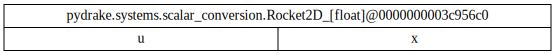

<pydrake.systems.framework.Diagram_[float] at 0x7f98ea050770>

In [8]:
draw_rocket(np.array([0,10, np.pi / 3, 0, 0,0,0, 0]))

In [ ]:
def MakeBargeRocket():
    builder = DiagramBuilder()

    plant, scene = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelFromString(barge_urdf, "urdf")

    rocket = builder.AddSystem(Rocket2D_[float]())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"), scene)

    plant.Finalize()
    context = rocket.CreateDefaultContext()
    rocket.get_input_port().FixValue(context,[9.81,10])

    B = np.array([[1,0]])
    gain = builder.AddSystem(MatrixGain(B))
    gain.set_name("Actuator Mapping")
    builder.Connect(gain.get_output_port(), plant.get_actuation_input_port())
    builder.ExportInput(gain.get_input_port(), "ball_force")

    builder.ExportOutput(plant.get_state_output_port(), "continuous_state")
    builder.ExportOutput(scene.get_query_output_port(), "query")

    return builder.Build(), scene
    
def create_barge_and_rocket():


    builder = DiagramBuilder()

    meshcat.Delete()
    
    # add barge
    b,scene = MakeBargeRocket()
    barge = builder.AddSystem(b)
    meshcat.AddSlider('u', min=-30., max=30, step=.1, value=0.0)
    force_system = builder.AddSystem(MeshcatSliders(meshcat,['u']))
    builder.Connect(barge.GetOutputPort("continuous_state"),barge.get_input_port())
    MeshcatVisualizerCpp.AddToBuilder(builder, barge.GetOutputPort("query"),
                                      meshcat)


    print(barge.GetOutputPort("continuous_state").size())
    print(barge.get_input_port().size())

    # For reference, let's draw the diagram we've assembled:
    display(SVG(pydot.graph_from_dot_data(barge.GetGraphvizString())[0].create_svg()))

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    #diagram.Publish(context)

    # Set the initial conditions for the barge
    context.SetContinuousState([0, 0, 0, 20, 0, 0, 0, 0])
    #simulator.set_target_realtime_rate(1.0)
    

    print('Use the slider in the MeshCat controls to apply elbow torque.')
    print("Press 'Stop Simulation' in MeshCat to continue.")
    meshcat.AddButton('Stop Simulation')
    while meshcat.GetButtonClicks('Stop Simulation') < 1:
        simulator.AdvanceTo(simulator.get_context().get_time() + 0.001)
        
    meshcat.DeleteAddedControls()

#create_barge_and_rocket()

In [50]:
def dircol_rocket():
    builder = DiagramBuilder()
    rocket = builder.AddSystem(Rocket2D_[None]())
    scene_graph = builder.AddSystem(SceneGraph())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"),
                                scene_graph)

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph,
                                                   meshcat)

    
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-100, xmax=100, ymin=-10, ymax=100)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    x_traj = None
    u_traj = None

    # SNOPT is more reliable if we solve it twice.
    for N in [25, 41]:
    # for N in [61]:
        dircol = DirectCollocation(rocket, rocket.CreateDefaultContext(), N,
                                0.5 / N, 10.0 / N, assume_non_continuous_states_are_fixed=True)
        prog = dircol.prog()
        dircol.AddEqualTimeIntervalsConstraints()

        # Input limits
        u = dircol.input()
        dircol.AddConstraintToAllKnotPoints(u[0] <= 50)
        dircol.AddConstraintToAllKnotPoints(u[0] >= 0)
        dircol.AddConstraintToAllKnotPoints(u[1] <= 10)
        dircol.AddConstraintToAllKnotPoints(u[1] >= -10)

        barge_speed = 5.0

        # Initial conditions
        s0 = RocketBargeState(np.zeros(8))
        s0.z = 50
        s0.x = 0
        s0.theta = 3.1415/2
        s0.xdot = 10
        s0.bargeX = 0
        s0.bargeXdot = barge_speed

        
        prog.AddBoundingBoxConstraint(s0[:], s0[:], dircol.initial_state())
        context.SetContinuousState(s0[:])
        diagram.Publish(context)

        # Final conditions
        sf = RocketBargeState(dircol.final_state())
        prog.AddBoundingBoxConstraint(-2,2, sf.x)
        # dircol.AddLinearConstraint(sf.x <= 1)
        # dircol.AddLinearConstraint(sf.x >= -1)
        prog.AddBoundingBoxConstraint(5, 5, sf.z)
        prog.AddBoundingBoxConstraint(0,0, sf.theta)
        prog.AddBoundingBoxConstraint(0 , 0 , sf.xdot)
        prog.AddBoundingBoxConstraint(0, 0, sf.zdot)
        prog.AddBoundingBoxConstraint(0,0, sf.thetadot)

        # State constraints
        s = RocketBargeState(dircol.state())
        dircol.AddConstraintToAllKnotPoints(s.z >= 5)
        dircol.AddConstraintToAllKnotPoints(s.bargeXdot == barge_speed)

        # Cost
        # dircol.AddRunningCost(0.00001*(u[1]**2))
        # dircol.AddRunningCost(1000*(u[0] + 1000*(u[1]**2)**0.5))
        dircol.AddRunningCost(1000*(u[0]**2 + 100*u[1]**2))

        # time constraint
        # dircol.AddDurationBounds(0,4)


        sf_d = RocketBargeState(np.zeros(8))
        prog.AddQuadraticErrorCost(np.diag([10, 10, 1, 0, 10, 10, 0, 0]), sf_d[:],
                                dircol.final_state())

        # def plot_trajectory(times, states):
        #     s = RocketBargeState(states)
        #     vertices = np.vstack([s.x, 0*s.x, s.z])
        #     meshcat.SetLine("dircol", vertices, rgba=Rgba(0, 0, 0.5))

        # dircol.AddStateTrajectoryCallback(plot_trajectory)

        if x_traj and u_traj:
            dircol.SetInitialTrajectory(u_traj, x_traj)
        else:
            initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
                [0., .8], np.column_stack((s0[:], sf_d[:])))
            dircol.SetInitialTrajectory(PiecewisePolynomial(),
                                        initial_x_trajectory)

        options = SolverOptions()
        options.SetOption(CommonSolverOption.kPrintToConsole, 1)
        prog.SetSolverOptions(options)

        # print(prog)

        result = Solve(prog)
        infeasible_constraints = result.GetInfeasibleConstraints(prog)
        for c in infeasible_constraints:
            print(f"infeasible constraint: {c}")
        assert result.is_success()

        x_traj = dircol.ReconstructStateTrajectory(result)
        u_traj = dircol.ReconstructInputTrajectory(result)

    # Animate trajectory

    visualizer.StartRecording()
    for t in np.hstack((np.arange(x_traj.start_time(), x_traj.end_time(),
                                  1.0/32.0), x_traj.end_time())):
        context.SetTime(t)
        context.SetContinuousState(x_traj.value(t))
        diagram.Publish(context)

    visualizer.StopRecording()
    visualizer.PublishRecording()

    
    return x_traj, u_traj

x_traj, u_traj = dircol_rocket()

In [ ]:
# fuel consumption = constant*norm of thrust


total time:  7.584059547283486
total thrust:  92.16398431800468
total torque:  3.692582309041955


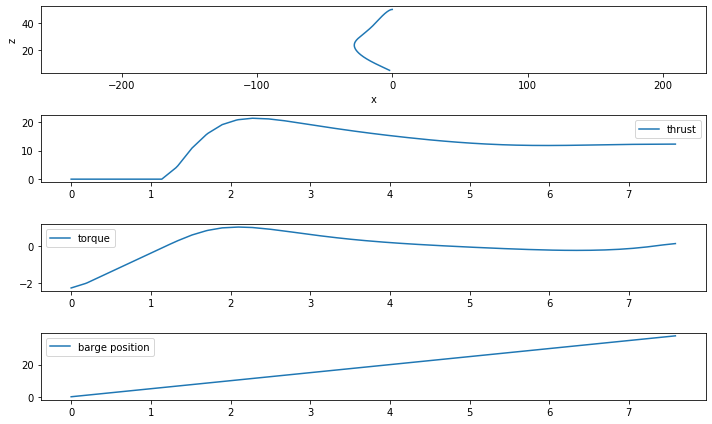

In [43]:
ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
s = RocketBargeState(x_traj.vector_values(ts))
u = u_traj.vector_values(ts)

fig, ax = plt.subplots(4,1, figsize=(10,6))
ax[0].plot(s.x, s.z)
ax[0].set_xlabel('x')
ax[0].set_ylabel('z')
ax[0].axis('equal')
ax[1].plot(ts, u[0], label='thrust')
ax[1].legend()
ax[2].plot(ts, u[1], label='torque')
ax[2].legend()
ax[3].plot(ts, s.bargeX, label='barge position')
ax[3].legend()
fig.tight_layout()

# calculate total thrust and torque, NOTE: this only works if u's are evenly spaces in time
total_time = u_traj.end_time() - u_traj.start_time() 
total_thrust = total_time * sum(abs(u[0]))/len(u[0])
total_torque = total_time * sum(abs(u[1]))/len(u[1])
print("total time: ", total_time)
print("total thrust: ", total_thrust)
print("total torque: ", total_torque)


total time:  7.584059547283486
total thrust:  92.16398431800468
total torque:  3.692582309041955


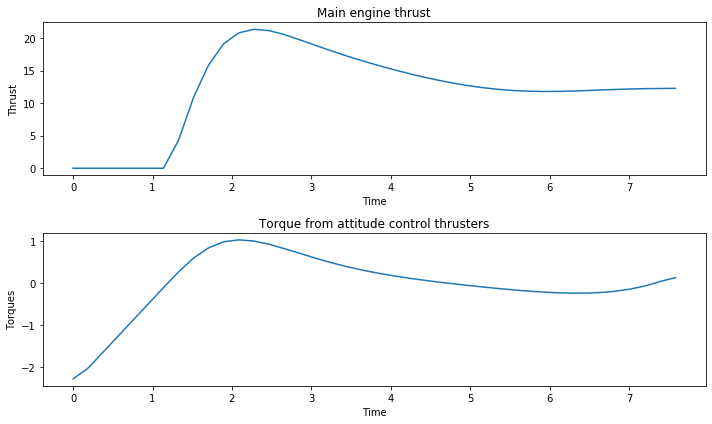

In [44]:
ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
s = RocketBargeState(x_traj.vector_values(ts))
u = u_traj.vector_values(ts)

fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(ts, u[0])
ax[0].title.set_text("Main engine thrust")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Thrust")
ax[1].plot(ts, u[1])
ax[1].title.set_text("Torque from attitude control thrusters")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Torques")
fig.tight_layout()

# calculate total thrust and torque, NOTE: this only works if u's are evenly spaces in time
total_time = u_traj.end_time() - u_traj.start_time() 
total_thrust = total_time * sum(abs(u[0]))/len(u[0])
total_torque = total_time * sum(abs(u[1]))/len(u[1])
print("total time: ", total_time)
print("total thrust: ", total_thrust)
print("total torque: ", total_torque)

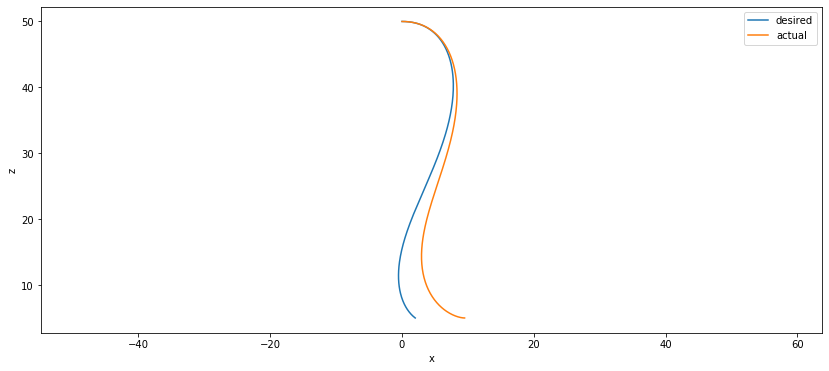

In [52]:
def open_loop_simulation(x_traj, u_traj):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(Rocket2D_[None]())
    scene_graph = builder.AddSystem(SceneGraph())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"),
                                scene_graph)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    logger = LogVectorOutput(rocket.GetOutputPort("x"), builder)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-100, xmax=100, ymin=-10, ymax=100)

    traj = builder.AddSystem(TrajectorySource(u_traj))
    builder.Connect(traj.get_output_port(), rocket.get_input_port())
    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    rocket_context = rocket.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = RocketBargeState(x_traj.vector_values(ts))

    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(desired_state.x, desired_state.z, label='desired')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.axis('equal')

    context.SetTime(x_traj.start_time())
    initial_state = RocketBargeState(x_traj.value(x_traj.start_time()))
    initial_state.bargeXdot += -0.5 # set the barge velocity to something differnt
    rocket_context.SetContinuousState(initial_state[:])

    visualizer.StartRecording(False)
    simulator.AdvanceTo(x_traj.end_time())
    visualizer.PublishRecording()

    log = logger.FindLog(context)
    state = RocketBargeState(log.data())
    ax.plot(state.x, state.z, label=f'actual')
    ax.legend()

open_loop_simulation(x_traj, u_traj)

In [ ]:
x_traj.breaks()

AttributeError: 'PiecewisePolynomial_[float]' object has no attribute 'breaks'

In [39]:
x_traj.end_time()

5.273429346939949

[4.50543932]
[4.81610667]
[5.64396263]
[5.09698721]
[5.46011545]


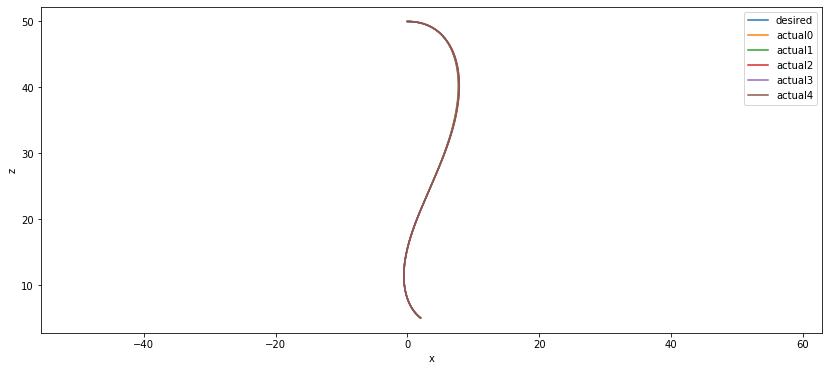

In [53]:
def finite_horizon_lqr(x_traj, u_traj):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(Rocket2D_[None]())
    scene_graph = builder.AddSystem(SceneGraph())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"),
                                scene_graph)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    logger = LogVectorOutput(rocket.GetOutputPort("x"), builder)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-100, xmax=100, ymin=-10, ymax=100)

    Q = np.diag([10, 10, 100, 0, 1, 1, 1, 0])
    R = np.diag([0.01, 0.01])
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.Qf = np.diag([(1 / 0.05)**2, (1 / 0.05)**2, (1 / 100.0)**2,
                          (1 / 3.0)**2, 1, 1, (1 / 3.0)**2, 1])
    #options.use_square_root_method = True  # Pending drake PR #16812
    options.x0 = x_traj
    options.u0 = u_traj

    controller = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(
            system=rocket,
            context=rocket.CreateDefaultContext(),
            t0=x_traj.start_time(),
            tf=x_traj.end_time(),
            Q=Q,
            R=R,
            options=options))
    builder.Connect(controller.get_output_port(), rocket.get_input_port())
    builder.Connect(rocket.GetOutputPort("x"), controller.get_input_port())

    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    rocket_context = rocket.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = RocketBargeState(x_traj.vector_values(ts))

    fig, ax = plt.subplots(2,1, figsize=(14,6))
    ax.plot(desired_state.x, desired_state.z, label='desired')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.axis('equal')

    rng = np.random.default_rng(123)

    for i in range(5):
        context.SetTime(x_traj.start_time())
        initial_state = RocketBargeState(x_traj.value(x_traj.start_time()))
        initial_state.bargeXdot += 0.5*rng.standard_normal()
        print(initial_state.bargeXdot)
        # initial_state.bargeXdot -=         
        rocket_context.SetContinuousState(initial_state[:])

        simulator.Initialize()
        visualizer.StartRecording(False)

        simulator.AdvanceTo(x_traj.end_time())
        visualizer.PublishRecording()

        log = logger.FindLog(context)
        state = RocketBargeState(log.data())
        log.Clear()

        ax.plot(state.x, state.z, label=f'actual{i}')
        
    
    ax.legend()

finite_horizon_lqr(x_traj, u_traj)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=48a3d090-8efd-4fd5-9847-d5e27a9acb16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>